In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path
import supy as sp
import os
from shutil import copyfile
import geopandas as gpd
import pickle
pd.options.mode.chained_assignment = None
from IPython.display import clear_output


In [2]:
sp.show_version()

supy: 2019.10.24  
supy_driver: 2019a17


In [3]:
def generate_array_dif(attrs_site, attr,level):
    dar = [0.25,0.25,.25]
    dar[level] = attrs_site[attr].values[0]
    return dar


def generate_array_same(attrs_site, attr):
    a = attrs_site[attr].values[0]
    return [a, a, a]


def modify_attr(df_state_init, df, name):

    all_attrs = pd.read_csv('all_attrs.csv')
    attrs_site = all_attrs[all_attrs.site == name]
    df_state_init.loc[:, 'emissionsmethod'] = 0
    df_state_init.loc[:,'roughlenheatmethod']=1
    

    if attrs_site.land.values[0] == 'DecTr':
        ar = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        level = 1
        df_state_init.albmin_dectr=attrs_site['albmin'].values[0]
        df_state_init.albmax_dectr=attrs_site['albmax'].values[0]
        df_state_init.albdectr_id=df_state_init.albmin_dectr
        df_state_init.loc[:, 'dectreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'EveTr':
        ar = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        level = 0
        df_state_init.albmin_evetr=attrs_site['albmin'].values[0]
        df_state_init.albmax_evetr=attrs_site['albmax'].values[0]
        df_state_init.albevetr_id=df_state_init.albmin_evetr
        df_state_init.loc[:, 'evetreeh'] = attrs_site.height.values[0]

    elif attrs_site.land.values[0] == 'Grass':
        ar = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        level = 2
        df_state_init.albmin_grass=attrs_site['albmin'].values[0]
        df_state_init.albmax_grass=attrs_site['albmax'].values[0]
        df_state_init.loc[:,'roughlenmommethod']=1
        df_state_init.albgrass_id=df_state_init.albmin_grass
        df_state_init.loc[:,'z0m_in']=attrs_site.height.values[0]*.1
        df_state_init.loc[:,'zdm_in']=attrs_site.height.values[0]*.7

    else:
        print('The land cover type is not found! using the default one')

    df_state_init.loc[:, 'sfr'] = ar
    df_state_init.loc[:, 'lat'] = df.Latitude.values[0].values[0]
    df_state_init.loc[:, 'lng'] = df.Longitude.values[0].values[0]
    df_state_init.loc[:, 'z'] = attrs_site.meas.values[0]
    df_state_init.loc[:, 'laimin'] = generate_array_dif(attrs_site, 'laimin',level)
    df_state_init.loc[:, 'laimax'] = generate_array_dif(attrs_site, 'laimax',level)
    df_state_init.loc[:, 'gddfull'] = generate_array_same(attrs_site, 'gddfull')
    df_state_init.loc[:, 'sddfull'] = generate_array_same(attrs_site, 'sddfull')
    df_state_init.loc[:, 'basete'] = generate_array_same(attrs_site, 'basete')
    df_state_init.loc[:, 'baset'] = generate_array_same(attrs_site, 'baset')
    df_state_init.lai_id = df_state_init.loc[:, 'laimin']
    
    

    return df_state_init,level


def func_parse_date(year, doy, hour, min):
    dt = pd.to_datetime(' '.join([str(k) for k in [year, doy, hour, min]]),
                        format='%Y %j %H %M')
    return dt


In [4]:
# name='crop'

# df = pd.read_csv('MODIS_LAI_AmeriFlux/statistics_Lai_500m-' + name +
#                  '.csv')
# if name!='crop':
#     df.columns = ['product'
#                   ] + [i.split(' ')[1] for i in df.columns if i != 'product']

# df = df.filter(['modis_date', 'value_mean'])

# df_period = df
# df_period.loc[:, 'year'] = [
#     int(i.split('A')[1][0:4]) for i in df_period.modis_date
# ]
# df_period.loc[:, 'DOY'] = [
#     int(i.split('A' + str(year))[1]) for i,year in zip(df_period.modis_date,df_period.year)
# ]
# df_period = df_period.set_index('DOY')
# df_period['datetime']=[datetime.datetime(year, 1, 1) + datetime.timedelta(x- 1) for x,year in 
#                        zip(df_period.index,df_period.year)]

# copyfile("./runs/data/" + name + "_" + 'all' + "_data_60.txt",
#          "runs/run/input/Kc_2012_data_60.txt")
# df_forcing = pd.read_csv('runs/run' + '/Input/' + 'kc' + '_' + '2012' +
#                          '_data_60.txt',
#                          sep=' ',
#                          parse_dates={'datetime': [0, 1, 2, 3]},
#                          keep_date_col=True,
#                          date_parser=func_parse_date)

# all_sites_info = pd.read_csv('site_info.csv')
# site_info = all_sites_info[all_sites_info['Site Id'] == name]
# df = pd.DataFrame({
#     'Site': [name],
#     'Latitude': [site_info['Latitude (degrees)']],
#     'Longitude': [site_info['Longitude (degrees)']]
# })

# path_runcontrol = Path('runs/run' + '/') / 'RunControl.nml'
# df_state_init = sp.init_supy(path_runcontrol)


# grid = df_state_init.index[0]
# df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

In [5]:
# year=2016

# if year==2014:
#     date1='2014-06-21'
#     date2='2014-11-09'
#     date1_1=datetime.datetime(2014,8,5)
#     date1_2=datetime.datetime(2014,10,1)
# elif year==2015:
#     date1='2015-06-20'
#     date2='2015-11-07'
#     date1_1=datetime.datetime(2015,8,10)
#     date1_2=datetime.datetime(2015,10,2)
# elif year==2016:
#     date1='2016-06-16'
#     date2='2016-11-05'
#     date1_1=datetime.datetime(2016,8,6)
#     date1_2=datetime.datetime(2016,10,1)
    
# name='crop'
# df_forcing_run_2=df_forcing_run.loc[date1:date2]
# df_state_init ,level= modify_attr(df_state_init, df, name)
# df_state_init.loc[:,'sdd_id']=[0,0,0]
# df_output, df_state_final = sp.run_supy(df_forcing_run_2,
#                                         df_state_init,
#                                         save_state=False)

# fig, axs = plt.subplots(1,2,figsize=(17,5))

# ax=axs[0]
# df_output_2 = df_output.loc[grid, :]
# a=df_period.filter(['datetime','value_mean']).set_index('datetime').loc[date1:date2]
# a.plot(ax=ax,marker='o',color='b')
# ax.tick_params(axis='y', labelcolor='b')                                                                                       
# ax.set_ylabel('LAI (MODIS)',color='b')



# ax1=ax.twinx()
# GDD_s=0.5*(df_forcing_run_2.Tair.resample('1D').max()+df_forcing_run_2.Tair.resample('1D').min())
# b=GDD_s.cumsum()
# b[a.index].plot(ax=ax1,alpha=0.5,color='r')
# ax1.tick_params(axis='y', labelcolor='r')
# ax1.set_ylabel('GDD (baseT=0 $\degree$C)',color='r')



# bb=b[b.index==date1_1]

# val1=np.round(bb.values.copy()[0],1)
# bb.iloc[0]=4
# bb=bb.append(bb)
# bb.iloc[1]=0
# bb.plot(ax=ax,color='k',linestyle='--')


# bb=b[b.index==date1_2]
# val2=np.round(bb.values.copy()[0],1)
# bb.iloc[0]=4
# bb=bb.append(bb)
# bb.iloc[1]=0
# bb.plot(ax=ax,color='m',linestyle='--')

# ax.set_ylim([0,5])
# ax.legend(['LAI','Start of reproductive: GDD =  '+str(val1),'Start of ripenning: GDD =  '+str(val2)])
# plt.title('Rice-'+date1[0:4]+'-'+str(int(date1[0:4])+1))






# if year==2014:
#     date1='2014-12-15'
#     date2='2015-05-31'
#     date1_1=datetime.datetime(2015,5,1)
#     date1_2=datetime.datetime(2015,4,16)
# elif year==2015:
#     date1='2015-12-10'
#     date2='2016-05-25'
#     date1_1=datetime.datetime(2016,5,1)
#     date1_2=datetime.datetime(2016,4,17)
# elif year==2016:
#     date1='2016-12-14'
#     date2='2017-05-31'
#     date1_1=datetime.datetime(2017,5,1)
#     date1_2=datetime.datetime(2017,4,15)
    
# name='crop2'
# df_forcing_run_2=df_forcing_run.loc[date1:date2]
# df_state_init ,level= modify_attr(df_state_init, df, name)
# df_state_init.loc[:,'sdd_id']=[0,0,0]
# df_output, df_state_final = sp.run_supy(df_forcing_run_2,
#                                         df_state_init,
#                                         save_state=False)
# ax=axs[1]

# df_output_2 = df_output.loc[grid, :]
# a=df_period.filter(['datetime','value_mean']).set_index('datetime').loc[date1:date2]
# a.plot(ax=ax,marker='o',color='b')
# ax.tick_params(axis='y', labelcolor='b')                                                                                       
# ax.set_ylabel('LAI (MODIS)',color='b')



# ax1=ax.twinx()
# GDD_s=0.5*(df_forcing_run_2.Tair.resample('1D').max()+df_forcing_run_2.Tair.resample('1D').min())
# b=GDD_s.cumsum()
# b[a.index].plot(ax=ax1,alpha=0.5,color='r')
# ax1.tick_params(axis='y', labelcolor='r')
# ax1.set_ylabel('GDD (baseT=0 $\degree$C)',color='r')



# bb=b[b.index==date1_1]
# val1=np.round(bb.values.copy()[0],1)
# bb.iloc[0]=4
# bb=bb.append(bb)
# bb.iloc[1]=0
# bb.plot(ax=ax,color='k',linestyle='--')


# bb=b[b.index==date1_2]
# val2=np.round(bb.values.copy()[0],1)
# bb.iloc[0]=4
# bb=bb.append(bb)
# bb.iloc[1]=0
# bb.plot(ax=ax,color='m',linestyle='--')

# ax.set_ylim([0,3])
# ax.legend(['LAI','Start of reproductive: GDD =  '+str(val1),'Start of ripenning: GDD =  '+str(val2)])
# plt.title('Wheat-'+date1[0:4]+'-'+str(int(date1[0:4])+1))
# plt.savefig(date1[0:4]+'-'+str(int(date1[0:4])+1)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)


In [6]:
# year=2014

# if year==2014:
#     date2=datetime.datetime(2014,11,30)
#     date2_0=datetime.datetime(2014,12,15)
#     date2_1=datetime.datetime(2015,5,1)
#     date2_2=datetime.datetime(2015,4,16)
#     date2_3=datetime.datetime(2015,5,31)
    
#     date1=datetime.datetime(2014,5,15)
#     date1_0=datetime.datetime(2014,6,21)
#     date1_1=datetime.datetime(2014,8,5)
#     date1_2=datetime.datetime(2014,10,1)
#     date1_3=datetime.datetime(2014,11,9)
    
# elif year==2015:
    
#     date2=datetime.datetime(2015,11,30)
#     date2_0=datetime.datetime(2015,12,10)
#     date2_1=datetime.datetime(2016,5,1)
#     date2_2=datetime.datetime(2016,4,17)
#     date2_3=datetime.datetime(2016,5,25)
    
#     date1=datetime.datetime(2015,5,15)
#     date1_0=datetime.datetime(2015,6,20)    
#     date1_1=datetime.datetime(2015,8,10)
#     date1_2=datetime.datetime(2015,10,2)
#     date1_3=datetime.datetime(2015,11,7)
    
# elif year==2016:
    
#     date2=datetime.datetime(2016,11,30)
#     date2_0=datetime.datetime(2016,12,14)
#     date2_1=datetime.datetime(2017,5,1)
#     date2_2=datetime.datetime(2017,4,15)
#     date2_3=datetime.datetime(2017,5,31)
    
#     date1=datetime.datetime(2016,5,15)
#     date1_0=datetime.datetime(2016,6,16)
#     date1_1=datetime.datetime(2016,8,6)
#     date1_2=datetime.datetime(2016,10,1)
#     date1_3=datetime.datetime(2016,11,5)


# fig,axs=plt.subplots(1,1,figsize=(10,5))
# df_all=pd.read_csv('Crop/all_date.csv')

# ax=axs
# p1=str(year)+' 04 20'
# p2=str(year+1)+' 06 10'
# df_all=df_all.set_index('time')
# df_all.index=pd.to_datetime(df_all.index)
# sub_df=df_all.loc[p1:p2]
# sub_df.index=pd.to_datetime(sub_df.index)
# sub_df=sub_df.resample('1h').mean()
# SWOUT=sub_df[(sub_df.index.hour>10)&(sub_df.index.hour<14 )].SWOUT.resample('1D').mean()
# SWIN=sub_df[(sub_df.index.hour>10)&(sub_df.index.hour<14 )].SWIN.resample('1D').mean()
# albedo=SWOUT/SWIN
# albedo=albedo[albedo.between(0,.2)]



# ax.scatter(albedo.index,albedo)

# ax.plot([date1,date1],[0.07,.2],color='b',linestyle='-')
# ax.plot([date1_0,date1_0],[0.07,.2],color='g',linestyle='-')
# ax.plot([date1_1,date1_1],[0.07,.2],color='m',linestyle='-')
# ax.plot([date1_2,date1_2],[0.07,.2],color='k',linestyle='-')
# ax.plot([date1_3,date1_3],[0.07,.2],color='y',linestyle='-')

# ax.plot([date2,date2],[0.07,.2],color='b',linestyle='--')
# ax.plot([date2_0,date2_0],[0.07,.2],color='g',linestyle='--')
# ax.plot([date2_1,date2_1],[0.07,.2],color='k',linestyle='--')
# ax.plot([date2_2,date2_2],[0.07,.2],color='m',linestyle='--')
# ax.plot([date2_3,date2_3],[0.07,.2],color='y',linestyle='--')

# xt=ax.get_xticks()
# ax1=ax.twinx()
# a=df_period.set_index('datetime').filter(['value_mean']).loc[p1:p2]
# a.plot(linestyle='--',alpha=0.8,color='r',ax=ax1,legend=False)


# ax1.set_ylabel('LAI',color='r')
# ax1.tick_params(axis='y', labelcolor='r') 
# ax.tick_params(axis='x', rotation=45) 
# ax.set_ylabel('albedo')
# ax.set_title(str(year)+'-'+str(year+1))

# ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*.2,0.19,'Rice',fontsize=20,color='k')
# ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*.75,0.19,'Wheat',fontsize=20,color='k')

# ax.plot([],[],color='b',label='Planting')
# ax.plot([],[],color='g',label='Start of vegetative period')
# ax.plot([],[],color='m',label='start of reproductive period')
# ax.plot([],[],color='k',label='start of ripening period')
# ax.plot([],[],color='y',label='End of ripening priod (harvest)')
# ax.plot([],[],color='k',linestyle='-',label='Rice')
# ax.plot([],[],color='k',linestyle='--',label='Wheat')
# ax.plot([],[],marker='o',linestyle='',label='albedo')
# ax.plot([],[],color='r',linestyle='--',label='LAI')
# ax.legend(bbox_to_anchor=(1.06, .9),fontsize=12)

# plt.savefig('LAI_albedo_Crop-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [7]:
# year=2014

# if year==2014:
#     date2=datetime.datetime(2014,11,30)
#     date2_0=datetime.datetime(2014,12,15)
#     date2_1=datetime.datetime(2015,5,1)
#     date2_2=datetime.datetime(2015,4,16)
#     date2_3=datetime.datetime(2015,5,31)
    
#     date1=datetime.datetime(2014,6,10)
#     date1_0=datetime.datetime(2014,6,21)
#     date1_1=datetime.datetime(2014,8,5)
#     date1_2=datetime.datetime(2014,10,1)
#     date1_3=datetime.datetime(2014,11,9)
    
# elif year==2015:
    
#     date2=datetime.datetime(2015,11,30)
#     date2_0=datetime.datetime(2015,12,10)
#     date2_1=datetime.datetime(2016,5,1)
#     date2_2=datetime.datetime(2016,4,17)
#     date2_3=datetime.datetime(2016,5,25)
    
#     date1=datetime.datetime(2015,6,10)
#     date1_0=datetime.datetime(2015,6,20)    
#     date1_1=datetime.datetime(2015,8,10)
#     date1_2=datetime.datetime(2015,10,2)
#     date1_3=datetime.datetime(2015,11,7)
    
# elif year==2016:
    
#     date2=datetime.datetime(2016,11,30)
#     date2_0=datetime.datetime(2016,12,14)
#     date2_1=datetime.datetime(2017,5,1)
#     date2_2=datetime.datetime(2017,4,15)
#     date2_3=datetime.datetime(2017,5,31)
    
#     date1=datetime.datetime(2016,6,10)
#     date1_0=datetime.datetime(2016,6,16)
#     date1_1=datetime.datetime(2016,8,6)
#     date1_2=datetime.datetime(2016,10,1)
#     date1_3=datetime.datetime(2016,11,5)


    
    
# name='cropr'
    
# df = pd.read_csv('MODIS_LAI_AmeriFlux/statistics_Lai_500m-' + name +
#                  '.csv')

# df = df.filter(['modis_date', 'value_mean'])

# df_period = df
# df_period.loc[:, 'year'] = [
#     int(i.split('A')[1][0:4]) for i in df_period.modis_date
# ]
# df_period.loc[:, 'DOY'] = [
#     int(i.split('A' + str(year))[1]) for i,year in zip(df_period.modis_date,df_period.year)
# ]
# df_period = df_period.set_index('DOY')
# df_period['datetime']=[datetime.datetime(year, 1, 1) + datetime.timedelta(x- 1) for x,year in 
#                        zip(df_period.index,df_period.year)]



# fig,axs=plt.subplots(1,1,figsize=(10,5))
# df_all=pd.read_csv('Crop/all_date.csv')

# ax=axs
# p1=str(year)+' 04 20'
# p2=str(year+1)+' 06 10'
# # p2=str(year)+' 12 01'
# df_all=df_all.set_index('time')
# df_all.index=pd.to_datetime(df_all.index)
# sub_df=df_all.loc[p1:p2]
# sub_df.index=pd.to_datetime(sub_df.index)
# sub_df=sub_df.resample('1h').mean()
# filled=sp.util.fill_gap_all(sub_df.TA)
# sub_df.TA=filled
# GDD_s=0.5*(sub_df.TA.resample('1D').max()+sub_df.TA.resample('1D').min())
# GDD_s.loc[:date1]=0
# b=GDD_s.cumsum()


# # ax.plot(b.index,b)

# f=[0,2]
# ax.plot([date1,date1],f,color='b',linestyle='-')
# ax.plot([date1_0,date1_0],f,color='g',linestyle='-')
# ax.plot([date1_1,date1_1],f,color='m',linestyle='-')
# ax.plot([date1_2,date1_2],f,color='k',linestyle='-')
# ax.plot([date1_3,date1_3],f,color='y',linestyle='-')

# ax.plot([date2,date2],f,color='b',linestyle='--')
# ax.plot([date2_0,date2_0],f,color='g',linestyle='--')
# ax.plot([date2_1,date2_1],f,color='k',linestyle='--')
# ax.plot([date2_2,date2_2],f,color='m',linestyle='--')
# ax.plot([date2_3,date2_3],f,color='y',linestyle='--')


# xt=ax.get_xticks()
# # ax1=ax.twinx()
# ax1=ax
# a=df_period.set_index('datetime').filter(['value_mean']).loc[p1:p2]
# ax1.plot(a.index,a,linestyle='',marker='o',alpha=0.8,color='b')


# lai_min=0.5
# lai=(b-135)*0.00118+lai_min
# lai_max=2.25
# lai[lai>lai_max]=lai_max
# lai[b<135]=lai_min
# sec_gdd=b[lai[lai==lai_max].index]
# lai.loc[lai[lai==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*0.00118
# lai[lai<lai_min]=lai_min





# ############
# GDD_s=0.5*(sub_df.TA.resample('1D').max()+sub_df.TA.resample('1D').min())
# GDD_s.loc[:date2]=0
# b=GDD_s.cumsum()

# lai_min=0.3
# lai2=(b-89)*0.00375+lai_min
# lai_max=2
# lai2[lai2>lai_max]=lai_max
# lai2[b<89]=lai_min
# sec_gdd=b[lai2[lai2==lai_max].index]
# lai2.loc[lai2[lai2==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*0.0025
# lai2[lai2<lai_min]=lai_min


# lai.loc[date2:]=lai2.loc[date2:]
# lai=lai[date1:]
# lai.plot(ax=ax1,color='r',linestyle='--',label='LAI Model')


# ax1.set_ylabel('LAI')
# # ax1.tick_params(axis='y', labelcolor='r') 
# ax.tick_params(axis='x', rotation=45) 
# ax.set_ylabel('LAI')
# ax.set_title(str(year)+'-'+str(year+1))

# ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*.2,0.19,'Rice',fontsize=20,color='k')
# ax.text(ax.get_xlim()[0]+(ax.get_xlim()[1]-ax.get_xlim()[0])*.75,0.19,'Wheat',fontsize=20,color='k')


# plt.plot([],[],color='b',linestyle='',marker='o',label='LAI MODIS')
# plt.plot([],[],color='b',label='Planting')
# plt.plot([],[],color='g',label='Start of vegetative period')
# plt.plot([],[],color='m',label='Start of reproductive period')
# plt.plot([],[],color='k',label='Start of ripening period')
# plt.plot([],[],color='y',label='End of ripening priod (harvest)')
# plt.plot([],[],color='k',linestyle='-',label='Rice')
# plt.plot([],[],color='k',linestyle='--',label='Wheat')

# plt.legend(bbox_to_anchor=(1.06, .9),fontsize=12)

# plt.savefig('LAI_albedo_Crop-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [8]:
def cal_alb_LAI(name,year,lai):
    
    if year==2014:
        date2=datetime.datetime(2014,11,30)
        date2_0=datetime.datetime(2014,12,15)
        date2_1=datetime.datetime(2015,5,1)
        date2_2=datetime.datetime(2015,4,16)
        date2_3=datetime.datetime(2015,5,31)

        date1=datetime.datetime(2014,6,10)
        date1_0=datetime.datetime(2014,6,21)
        date1_1=datetime.datetime(2014,8,5)
        date1_2=datetime.datetime(2014,10,1)
        date1_3=datetime.datetime(2014,11,9)
    
    elif year==2015:
        date2=datetime.datetime(2015,11,30)
        date2_0=datetime.datetime(2015,12,10)
        date2_1=datetime.datetime(2016,5,1)
        date2_2=datetime.datetime(2016,4,17)
        date2_3=datetime.datetime(2016,5,25)

        date1=datetime.datetime(2015,6,10)
        date1_0=datetime.datetime(2015,6,20)    
        date1_1=datetime.datetime(2015,8,10)
        date1_2=datetime.datetime(2015,10,2)
        date1_3=datetime.datetime(2015,11,7)

    elif year==2016:
        date2=datetime.datetime(2016,11,30)
        date2_0=datetime.datetime(2016,12,14)
        date2_1=datetime.datetime(2017,5,1)
        date2_2=datetime.datetime(2017,4,15)
        date2_3=datetime.datetime(2017,5,31)

        date1=datetime.datetime(2016,6,10)
        date1_0=datetime.datetime(2016,6,16)
        date1_1=datetime.datetime(2016,8,6)
        date1_2=datetime.datetime(2016,10,1)
        date1_3=datetime.datetime(2016,11,5)
    
    
    df = pd.read_csv('MODIS_LAI_AmeriFlux/statistics_Lai_500m-' + name +
                     '.csv')

    df = df.filter(['modis_date', 'value_mean'])

    df_period = df
    df_period.loc[:, 'year'] = [
        int(i.split('A')[1][0:4]) for i in df_period.modis_date
    ]
    df_period.loc[:, 'DOY'] = [
        int(i.split('A' + str(year))[1]) for i,year in zip(df_period.modis_date,df_period.year)
    ]
    df_period = df_period.set_index('DOY')
    df_period['datetime']=[datetime.datetime(year, 1, 1) + datetime.timedelta(x- 1) for x,year in 
                           zip(df_period.index,df_period.year)]

    copyfile("./runs/data/" + 'crop' + "_" + 'all' + "_data_60.txt",
             "runs/run1/input/Kc_2012_data_60.txt")
    df_forcing = pd.read_csv('runs/run1' + '/Input/' + 'kc' + '_' + '2012' +
                             '_data_60.txt',
                             sep=' ',
                             parse_dates={'datetime': [0, 1, 2, 3]},
                             keep_date_col=True,
                             date_parser=func_parse_date)

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run1' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    if name=='cropr':
        d1=date1
        d2=date1_3
    elif name=='cropw':
        d1=date2
        d2=date2_3        


    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai.loc[d1:d2]
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')


    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    df_output, df_state_final = sp.run_supy(df_forcing_run_2,
                                            df_state_init,
                                            save_state=False)

    return df_output,df_period,grid,d1,d2


def cal_obs(df_period,d1,d2):
    lai_obs=df_period.set_index('datetime').filter(['value_mean']).loc[d1:d2]
    
    df_all=pd.read_csv('Crop/all_date.csv')
    df_all=df_all.set_index('time')
    df_all.index=pd.to_datetime(df_all.index)
    sub_df=df_all.loc[d1:d2]
    sub_df.index=pd.to_datetime(sub_df.index)
    sub_df=sub_df.resample('1h').mean()
    SWOUT=sub_df[(sub_df.index.hour>10)&(sub_df.index.hour<14 )].SWOUT.resample('1D').mean()
    SWIN=sub_df[(sub_df.index.hour>10)&(sub_df.index.hour<14 )].SWIN.resample('1D').mean()
    albedo=SWOUT/SWIN
    albedo=albedo[albedo.between(0,.2)]
    
    return lai_obs,albedo




def cal_all_lai_model(year):
    
    if year==2014:
        date2=datetime.datetime(2014,11,30)
        date2_0=datetime.datetime(2014,12,15)
        date2_1=datetime.datetime(2015,5,1)
        date2_2=datetime.datetime(2015,4,16)
        date2_3=datetime.datetime(2015,5,31)

        date1=datetime.datetime(2014,6,10)
        date1_0=datetime.datetime(2014,6,21)
        date1_1=datetime.datetime(2014,8,5)
        date1_2=datetime.datetime(2014,10,1)
        date1_3=datetime.datetime(2014,11,9)
    
    elif year==2015:
        date2=datetime.datetime(2015,11,30)
        date2_0=datetime.datetime(2015,12,10)
        date2_1=datetime.datetime(2016,5,1)
        date2_2=datetime.datetime(2016,4,17)
        date2_3=datetime.datetime(2016,5,25)

        date1=datetime.datetime(2015,6,10)
        date1_0=datetime.datetime(2015,6,20)    
        date1_1=datetime.datetime(2015,8,10)
        date1_2=datetime.datetime(2015,10,2)
        date1_3=datetime.datetime(2015,11,7)

    elif year==2016:
        date2=datetime.datetime(2016,11,30)
        date2_0=datetime.datetime(2016,12,14)
        date2_1=datetime.datetime(2017,5,1)
        date2_2=datetime.datetime(2017,4,15)
        date2_3=datetime.datetime(2017,5,31)

        date1=datetime.datetime(2016,6,10)
        date1_0=datetime.datetime(2016,6,16)
        date1_1=datetime.datetime(2016,8,6)
        date1_2=datetime.datetime(2016,10,1)
        date1_3=datetime.datetime(2016,11,5)
    
    df_all=pd.read_csv('Crop/all_date.csv')


    p1=str(year)+' 04 20'
    p2=str(year+1)+' 06 10'

    df_all=df_all.set_index('time')
    df_all.index=pd.to_datetime(df_all.index)
    sub_df=df_all.loc[p1:p2]
    sub_df.index=pd.to_datetime(sub_df.index)
    sub_df=sub_df.resample('1h').mean()
    filled=sp.util.fill_gap_all(sub_df.TA)
    sub_df.TA=filled
    GDD_s=0.5*(sub_df.TA.resample('1D').max()+sub_df.TA.resample('1D').min())
    GDD_s.loc[:date1]=0
    b=GDD_s.cumsum()

    lai_min=0.5
    lai=(b-135)*0.00118+lai_min
    lai_max=2.25
    lai[lai>lai_max]=lai_max
    lai[b<135]=lai_min
    sec_gdd=b[lai[lai==lai_max].index]
    lai.loc[lai[lai==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*0.00118
    lai[lai<lai_min]=lai_min


    ############
    GDD_s=0.5*(sub_df.TA.resample('1D').max()+sub_df.TA.resample('1D').min())
    GDD_s.loc[:date2]=0
    b=GDD_s.cumsum()

    lai_min=0.3
    lai2=(b-89)*0.00375+lai_min
    lai_max=2
    lai2[lai2>lai_max]=lai_max
    lai2[b<89]=lai_min
    sec_gdd=b[lai2[lai2==lai_max].index]
    lai2.loc[lai2[lai2==lai_max].index]=lai_max-(sec_gdd-sec_gdd.iloc[0])*0.0025
    lai2[lai2<lai_min]=lai_min


    lai.loc[date2:]=lai2.loc[date2:]
    lai=lai[date1:]

    return lai



In [84]:
year=2015
lai=cal_all_lai_model(year)

name='cropr'
df_output1,df_period1,grid,d11,d21=cal_alb_LAI(name,year,lai)
lai_obs1,albedo1=cal_obs(df_period1,d11,d21)

name='cropw'
df_output2,df_period2,grid,d12,d22=cal_alb_LAI(name,year,lai)
lai_obs2,albedo2=cal_obs(df_period2,d12,d22)

2019-11-19 13:04:33,973 — SuPy — INFO — All cache cleared.
2019-11-19 13:04:34,807 — SuPy — INFO — All cache cleared.
2019-11-19 13:04:36,829 — SuPy — INFO — ====================
2019-11-19 13:04:36,830 — SuPy — INFO — Simulation period:
2019-11-19 13:04:36,831 — SuPy — INFO —   Start: 2015-06-10 00:00:00
2019-11-19 13:04:36,831 — SuPy — INFO —   End: 2015-11-07 00:00:00
2019-11-19 13:04:36,833 — SuPy — INFO — 
2019-11-19 13:04:36,838 — SuPy — INFO — No. of grids: 1
2019-11-19 13:04:36,839 — SuPy — INFO — SuPy is running in serial mode
2019-11-19 13:04:45,539 — SuPy — INFO — Execution time: 8.7 s
2019-11-19 13:04:45,540 — SuPy — INFO — ====================

2019-11-19 13:04:49,989 — SuPy — INFO — All cache cleared.
2019-11-19 13:04:50,889 — SuPy — INFO — All cache cleared.
2019-11-19 13:04:52,660 — SuPy — INFO — ====================
2019-11-19 13:04:52,661 — SuPy — INFO — Simulation period:
2019-11-19 13:04:52,661 — SuPy — INFO —   Start: 2015-11-30 00:00:00
2019-11-19 13:04:52,662 — S

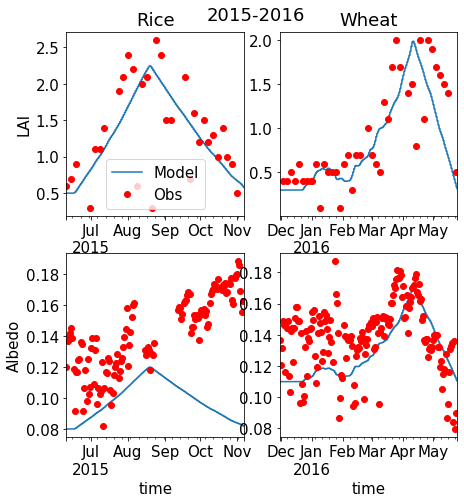

In [85]:
fig,axs=plt.subplots(2,2,figsize=(7,7))
plt.subplots_adjust(hspace=0.2)
fig.suptitle(str(year)+'-'+str(year+1))
fig.subplots_adjust(top=0.93)


ax=axs[0][0]
df_output1.loc[grid].SUEWS.LAI.resample('1h').mean().plot(ax=ax)
lai_obs1.plot(linestyle='',marker='o',color='r',ax=ax,legend=False)
ax.set_ylabel('LAI')
ax.set_title('Rice')
ax.set_xlabel('')

ax=axs[1][0]
df_output1.loc[grid].SUEWS.AlbBulk.resample('1h').mean().plot(ax=ax)
albedo1.plot(marker='o',color='r',linestyle='',ax=ax)
ax.set_ylabel('Albedo')


ax=axs[0][1]
df_output2.loc[grid].SUEWS.LAI.resample('1h').mean().plot(ax=ax)
lai_obs2.plot(linestyle='',marker='o',color='r',ax=ax,legend=False)
ax.set_title('Wheat')
ax.set_xlabel('')

ax=axs[1][1]
df_output2.loc[grid].SUEWS.AlbBulk.resample('1h').mean().plot(ax=ax)
albedo2.plot(marker='o',color='r',linestyle='',ax=ax)

ax=axs[0][0]

ax.legend(['Model','Obs'])

plt.savefig('all_Crop-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

# g2-g6 and g_max

In [11]:
from gs_util import cal_gs_obs,cal_gs_mod

In [12]:
def forcing(year,name,lai):
    if year==2014:
        date2=datetime.datetime(2014,11,30)
        date2_0=datetime.datetime(2014,12,15)
        date2_1=datetime.datetime(2015,5,1)
        date2_2=datetime.datetime(2015,4,16)
        date2_3=datetime.datetime(2015,5,31)

        date1=datetime.datetime(2014,6,10)
        date1_0=datetime.datetime(2014,6,21)
        date1_1=datetime.datetime(2014,8,5)
        date1_2=datetime.datetime(2014,10,1)
        date1_3=datetime.datetime(2014,11,9)
    
    elif year==2015:
        date2=datetime.datetime(2015,11,30)
        date2_0=datetime.datetime(2015,12,10)
        date2_1=datetime.datetime(2016,5,1)
        date2_2=datetime.datetime(2016,4,17)
        date2_3=datetime.datetime(2016,5,25)

        date1=datetime.datetime(2015,6,10)
        date1_0=datetime.datetime(2015,6,20)    
        date1_1=datetime.datetime(2015,8,10)
        date1_2=datetime.datetime(2015,10,2)
        date1_3=datetime.datetime(2015,11,7)

    elif year==2016:
        date2=datetime.datetime(2016,11,30)
        date2_0=datetime.datetime(2016,12,14)
        date2_1=datetime.datetime(2017,5,1)
        date2_2=datetime.datetime(2017,4,15)
        date2_3=datetime.datetime(2017,5,31)

        date1=datetime.datetime(2016,6,10)
        date1_0=datetime.datetime(2016,6,16)
        date1_1=datetime.datetime(2016,8,6)
        date1_2=datetime.datetime(2016,10,1)
        date1_3=datetime.datetime(2016,11,5)
    
    copyfile("./runs/data/" + 'crop' + "_" + 'all' + "_data_60.txt",
             "runs/run1/input/Kc_2012_data_60.txt")
    df_forcing = pd.read_csv('runs/run1' + '/Input/' + 'kc' + '_' + '2012' +
                             '_data_60.txt',
                             sep=' ',
                             parse_dates={'datetime': [0, 1, 2, 3]},
                             keep_date_col=True,
                             date_parser=func_parse_date)

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })

    path_runcontrol = Path('runs/run1' + '/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)


    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)

    if name=='cropr':
        d1=date1
        d2=date1_3
    elif name=='cropw':
        d1=date2
        d2=date2_3        


    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai.loc[d1:d2]
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')


    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]
    
    return df_forcing_run_2,df_state_init,grid,d1,d2
    
    
def calc_OHM(df_obs):
    df_obs=df_obs.replace(-999,np.nan)
    QS_obs=df_obs.qn-df_obs.qe-df_obs.qe
    QS_obs=QS_obs[QS_obs>-200]

    #plt.scatter(df_obs.loc[QS_obs.index].qn,QS_obs)
    plt.ylabel('QS_obs')
    plt.ylabel('QSTAR')

    QSTAR=df_obs.loc[QS_obs.index].qn
    all_df=pd.DataFrame()
    all_df['QSTAR']=QSTAR
    all_df['total_time']=(QSTAR.index-datetime.datetime(1970,1,1)).total_seconds()
    all_df=all_df.resample('T').interpolate().resample('1h').mean()



    diff=all_df.diff()
    diff.iloc[0]=diff.iloc[1]
    diff=diff.loc[QS_obs.index]
    dQSTARdt=diff.QSTAR/diff.total_time


    df=pd.DataFrame()
    df['QSTAR']=QSTAR
    df['dQSTARdt']=dQSTARdt*3600
    df['x0']=1

    X=df.values
    y=QS_obs

    coef=np.linalg.lstsq(np.vstack([X[:,0],X[:,1],X[:,2]]).T, y.values)[0]

    plt.scatter(QS_obs.values,X[:,0]*coef[0]+X[:,1]*coef[1]+X[:,2]*coef[2])
    plt.plot([-200,100],[-200,100],color='r',linestyle='--',label='1-1')
    plt.legend()
    plt.xlim([-200,100])
    plt.ylim([-200,100])
    return coef

# Calibrating QS OHM

2019-11-19 10:18:23,574 — SuPy — INFO — All cache cleared.
2019-11-19 10:18:24,374 — SuPy — INFO — All cache cleared.


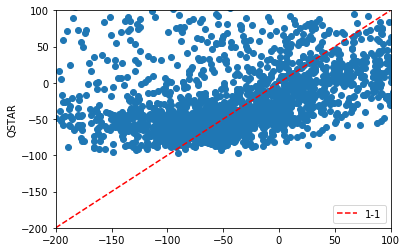

In [13]:
year=2015
name='cropw'
lai=cal_all_lai_model(year)
df_forcing_run_2,df_state_init,grid,d1,d2=forcing(year,name,lai)
df_obs=pd.read_csv('runs/run1'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
                                parse_dates={'datetime': [0, 1, 2, 3]},
                                keep_date_col=True,
                                date_parser=func_parse_date)
df_obs=df_obs.set_index('datetime')
df_obs=df_obs.loc[d1:d2]

coef=calc_OHM(df_obs)

In [14]:
coef

array([  0.17703989,   0.41273546, -45.70357277])

In [693]:
coef=[  0.17703989,   0.41273546, -45.70357277]
# coef=[0.5,0.21,-39.1]
coef[0]=1.6*coef[0]
coef[1]=1.9*coef[1]
coef[2]=-18
coef

[0.283263824, 0.784197374, -18]

In [694]:
year=2015
name='cropw'
lai=cal_all_lai_model(year)
df_forcing_run_2,df_state_init,grid,d1,d2=forcing(year,name,lai)

2019-11-19 16:26:17,705 — SuPy — INFO — All cache cleared.
2019-11-19 16:26:18,754 — SuPy — INFO — All cache cleared.


In [695]:
def irr_mod(df_state_init,df_forcing_run_2,year):
    df_state_init.loc[:,'surfacearea']=1
    df_state_init.loc[:,'waterusemethod']=1
    df_state_init.loc[:,'irrfracgrass']=1
    df_state_init.loc[:,'statelimit']=[0.48,0.25,1.3,0.8,   50  ,1.0,30000.0]
    df_state_init.loc[:,'wetthresh']=[0.48,0.25,1.3,0.8,   50  ,1.0,0.5]
    df_forcing_run_2.Wuh=0
    temp=df_forcing_run_2[df_forcing_run_2.index.hour==23]
    df_forcing_run_2.loc[temp.index,'Wuh']=(1*10000)*(5/100)
#     df_forcing_run_2.loc[str(year)+' 10 7':,'Wuh']=0
    return df_state_init,df_forcing_run_2
df_state_init,df_forcing_run_2=irr_mod(df_state_init,df_forcing_run_2,year)

In [696]:
path_runcontrol = Path('runs/run1'+'/') / 'RunControl.nml'
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]



error=10
for i in range(10):
    
    if (error <= 0.1):
        break
    df_output, df_state_final = sp.run_supy(df_forcing_run_2, df_state_init, save_state=False)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2019-11-19 16:26:22,075 — SuPy — INFO — ====================
2019-11-19 16:26:22,076 — SuPy — INFO — Simulation period:
2019-11-19 16:26:22,078 — SuPy — INFO —   Start: 2015-11-30 00:00:00
2019-11-19 16:26:22,080 — SuPy — INFO —   End: 2016-05-25 00:00:00
2019-11-19 16:26:22,081 — SuPy — INFO — 
2019-11-19 16:26:22,083 — SuPy — INFO — No. of grids: 1
2019-11-19 16:26:22,085 — SuPy — INFO — SuPy is running in serial mode
2019-11-19 16:26:32,477 — SuPy — INFO — Execution time: 10.4 s
2019-11-19 16:26:32,479 — SuPy — INFO — ====================

466.03555461238847
2019-11-19 16:26:32,926 — SuPy — INFO — ====================
2019-11-19 16:26:32,927 — SuPy — INFO — Simulation period:
2019-11-19 16:26:32,928 — SuPy — INFO —   Start: 2015-11-30 00:00:00
2019-11-19 16:26:32,929 — SuPy — INFO —   End: 2016-05-25 00:00:00
2019-11-19 16:26:32,931 — SuPy — INFO — 
2019-11-19 16:26:32,935 — SuPy — INFO — No. of grids: 1
2019-11-19 16:26:32,936 — SuPy — INFO — SuPy is running in serial mode
2019-11-

In [697]:
from atmosp import calculate as ac
def cal_des_dta(ta, pa, dta=1.0):
    """Calculate slope of es(Ta), i.e., saturation evaporation pressure `es` as function of air temperature `ta [K]`
    Parameters
    ----------
    ta : numeric
        Air temperature [K]
    pa : numeric
        Air pressure [Pa]
    dta : float, optional
        change in ta for calculating that in es, by default 1.0 K
    """

    des = ac('es', p=pa, T=ta + dta/2) - ac('es', p=pa, T=ta - dta/2)
    des_dta = des/dta
    try:
        # try to pack as Series
        des_dta = pd.Series(des_dta, index=ta.index)
    except AttributeError as ex:
        print(ex, 'cannot pack into pd.Series')
        pass
    return des_dta


def cal_rs_obs(qh, qe, ta, rh, pa,RA):
    """Calculate surface resistance based on observations, notably turbulent fluxes.
    Parameters
    ----------
    qh : numeric
        sensible heat flux [W m-2]
    qe : numeric
        latent heat flux [W m-2]
    ta : numeric
        air temperature [K]
    rh : numeric
        relative humidity [%]
    pa : numeric
        air pressure [Pa]
    Returns
    -------
    numeric
        Surface resistance based on observations [s m-1]
    """

    # surface resistance at water surface [s m-1]
    #rav = 100
    rav=RA

    # psychrometric constant [Pa K-1] as a function of air pressure
    ser_gamma = 0.665e-3 * pa

    # air density [kg m-3]
    val_rho = 1.27

    # heat capacity of air [J kg-1 K-1]
    val_cp = 1005

    # slope of es(Ta) curve at Ta
    ser_des_dTa = cal_des_dta(ta, pa, dta=1.0)
    #
    arr_e = ac('e', p=pa, T=ta, RH=rh)
    arr_es = ac('es', p=pa, T=ta)
    arr_vpd = arr_es-arr_e
    #
    ser_rs_1 = ((ser_des_dTa / ser_gamma)*(qh / qe) - 1) * rav
    ser_rs_2 = (val_rho * val_cp * arr_vpd / (ser_gamma * qe))
    ser_rs = ser_rs_1 + ser_rs_2

    try:
        # try to pack as Series
        ser_rs = pd.Series(ser_rs, index=ta.index)
    except AttributeError as ex:
        print(ex, 'cannot pack into pd.Series')
        pass

    return ser_rs,ser_rs_1,ser_rs_2,ser_des_dTa,((ser_des_dTa / ser_gamma)*(qh / qe) - 1),arr_vpd 







def cal_gs_obs(qh, qe, ta, rh, pa,RA):
    """Calculate surface conductance based on observations, notably turbulent fluxes.
    Parameters
    ----------
    qh : numeric
        Sensible heat flux [W m-2]
    qe : numeric
        Latent heat flux [W m-2]
    ta : numeric
        Air temperature [K]
    rh : numeric
        Relative humidity [%]
    pa : numeric
        Air pressure [Pa]
    Returns
    -------
    numeric
        Surface conductance based on observations [mm s-1]
    """
    rs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,arr_vpd = cal_rs_obs(qh, qe, ta, rh, pa,RA)
    gs_obs = 1e3/rs_obs
    return gs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,arr_vpd

In [698]:
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()


df_forcing=pd.read_csv('runs/run1'+'/Input/'+'kc'+'_'+'2012'+'_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

df_forcing= df_forcing.set_index('datetime')
df_forcing=df_forcing.loc[d1:d2]

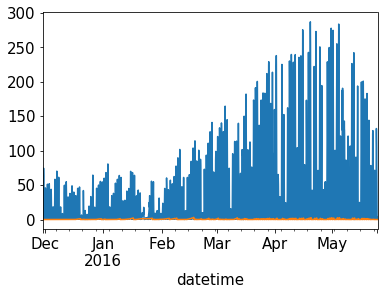

In [699]:
df.QE.plot()
df.SMD.plot()

In [700]:
g6max=5.56/df.SMD.max()
g6max

1.8460836193189818

In [701]:
g6min=5.56/150
g6min

0.037066666666666664

In [702]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[(df_forcing.qe > 0)&(df_forcing.qe < 900)]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs,ser_rs_1,ser_rs_2,ser_des_dTa,br,vpd = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)

df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

(-50, 400)

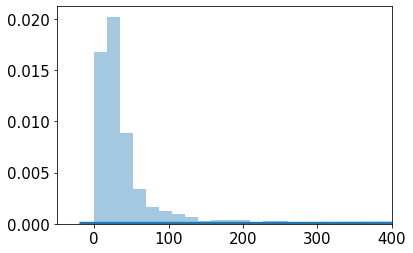

In [703]:
import seaborn as sns
sns.distplot(gs_obs.values,hist=True, kde=True,bins=int(2000),kde_kws={'linewidth': 4})
plt.xlim((-50,400))

In [704]:
g_max=np.percentile(gs_obs,99)
s1=5.56
g_max

707.1670605715536

In [705]:
df_forcing=df_forcing[gs_obs<g_max]
#lai_max=df_forcing.lai.max()
lai_max=df_state_init.laimax.loc[grid,:][2]
gs_obs=gs_obs[gs_obs<g_max]

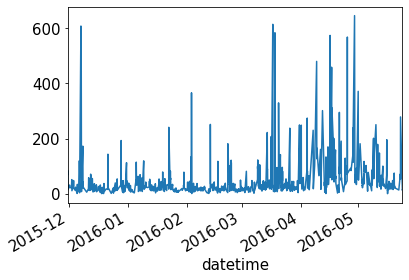

In [706]:
gs_obs.plot()

In [707]:
lai_max

2.0

In [708]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os

df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [709]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

In [710]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [711]:
problem = Problem(6,2,1)
problem.types[0] = Real(.1, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(g6min, 0.05)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
#algorithm=NSGAIII(problem, divisions_outer=12)
algorithm.run(3000)


In [712]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.207	1.115
0.524	0.754
0.148	1.200
0.398	0.872
0.383	0.889
0.224	1.094
0.219	1.098
0.475	0.795
0.370	0.904
0.454	0.814


Text(0, 0.5, 'objective 2')

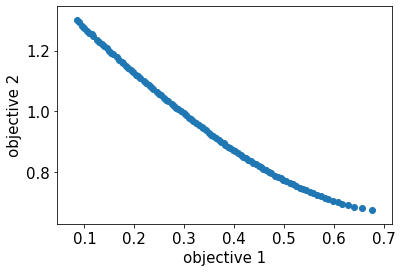

In [713]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

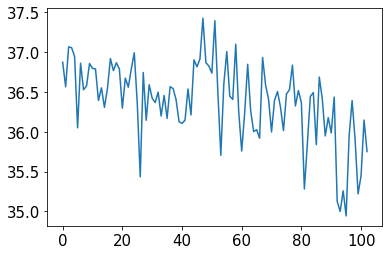

In [714]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [715]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

In [716]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.33835189613123007
0.9430012687863887


In [717]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [718]:
with open('g1-g6/'+name+'-g1-g6','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [719]:
with open('g1-g6/'+name+'-g1-g6','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [720]:

pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
cropw,0.365,105.071,0.071,0.532,36.421,0.039


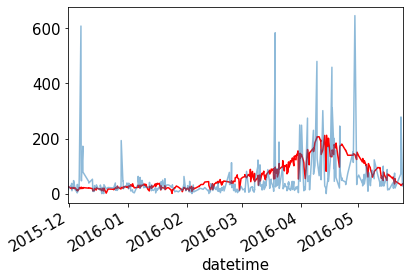

In [721]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r')
gs_train.plot(alpha=0.5)

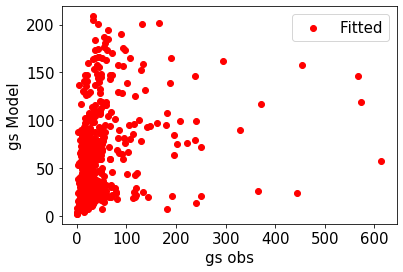

In [722]:
kd_test=df_forcing_test.kdown
ta_test=df_forcing_test.Tair
rh_test=df_forcing_test.RH
pa_test=df_forcing_test.pres
smd_test=df_forcing_test.xsmd
lai_test=df_forcing_test.lai



gs_model_test,g_lai,g_kd,g_dq,g_ta,g_smd,g_m=cal_gs_mod(kd_test, ta_test, rh_test, pa_test, smd_test, lai_test,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
# gs_model_helen,g_lai,g_kd,g_dq,g_ta,g_smd,g_m=cal_gs_mod(kd_test, ta_test, rh_test, pa_test, smd_test, lai_test,
#                           [3.5, 200, 0.13, 0.7, 30, .05],
#                           g_max, lai_max, s1)

plt.rc('font', size=15)
f, ax = plt.subplots(1, 1)
plt.scatter(gs_test.values,gs_model_test.values,color='r',alpha=1,label='Fitted')
#plt.scatter(gs_test.values,gs_model_helen.values,color='b',alpha=0.4,label='Helen')
plt.xlabel('gs obs')
plt.ylabel('gs Model')
plt.legend()
plt.savefig('figs/compare_test-gs-'+name+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)


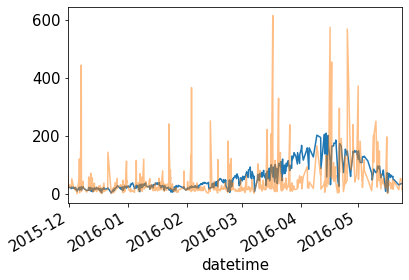

In [723]:
gs_model_test.plot()
gs_test.plot(alpha=0.5)

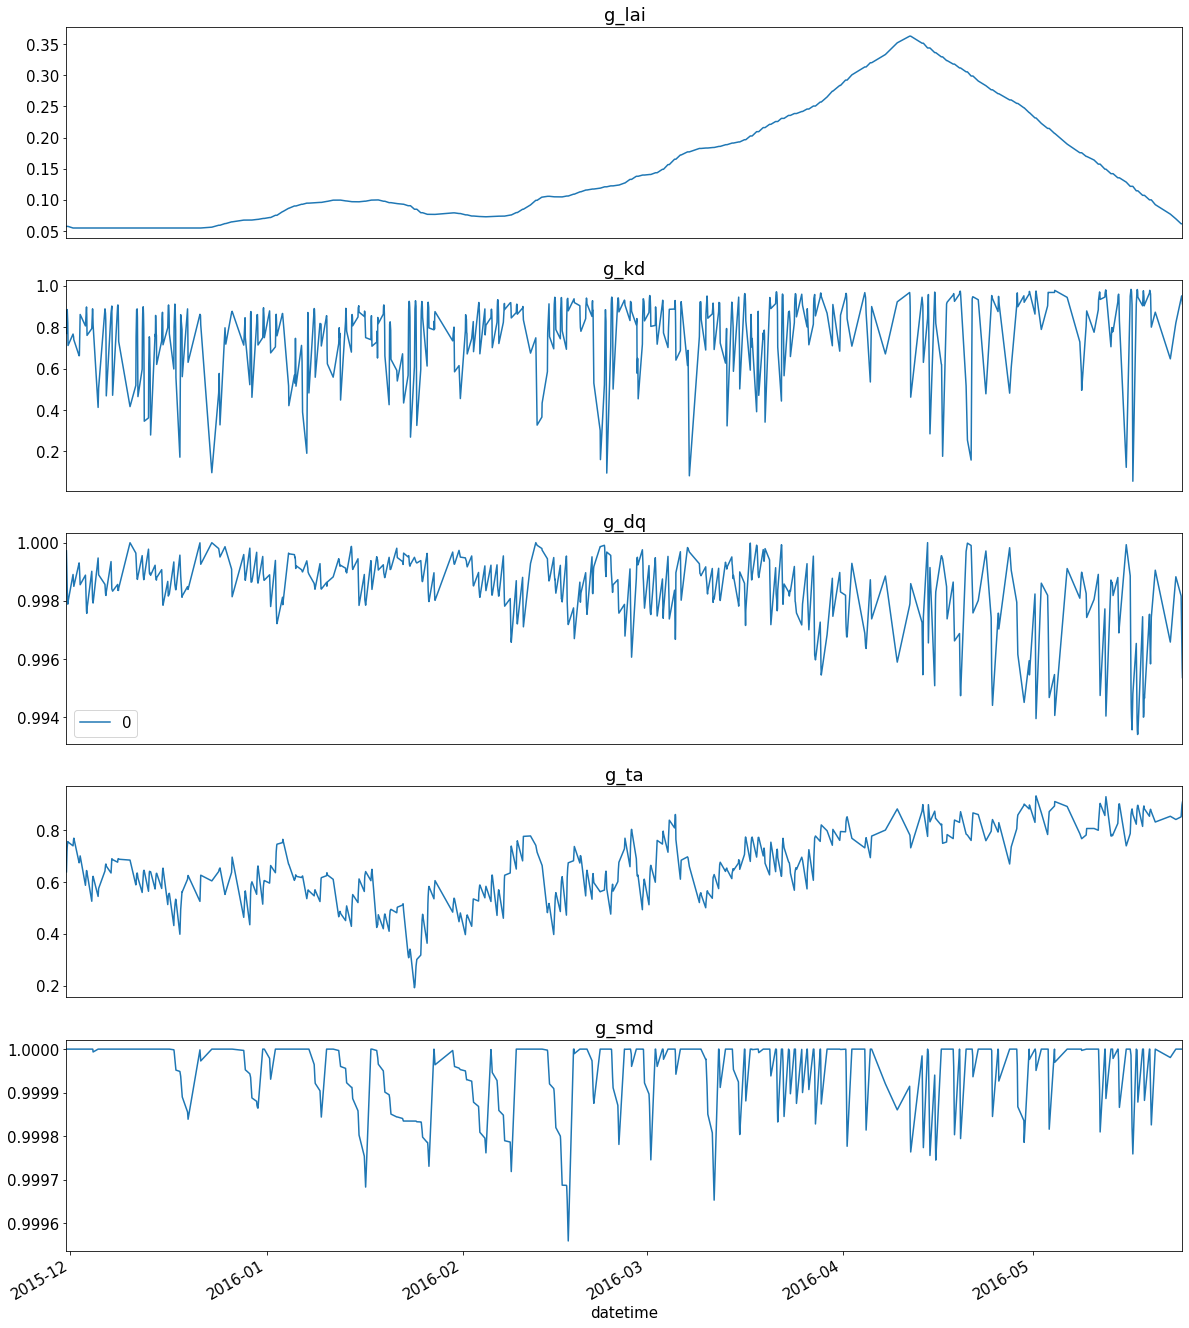

In [724]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    a[str(i)].plot(ax=ax)
    ax.set_title(b[str(i)])
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')
    
    

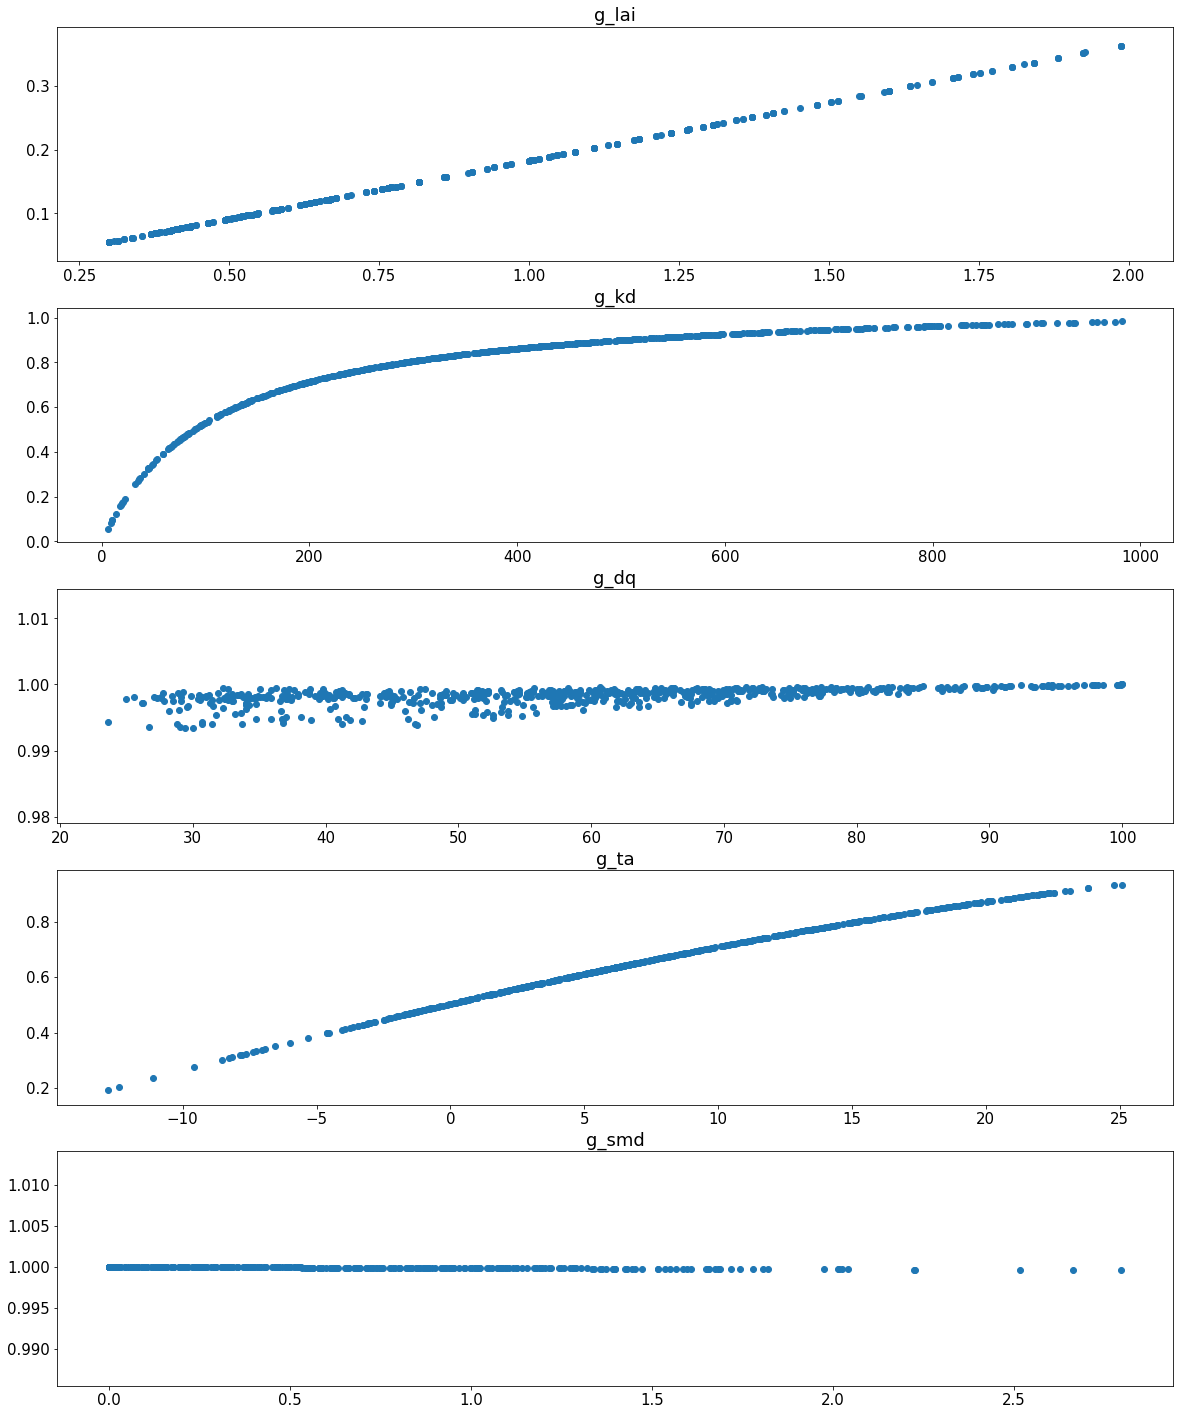

In [725]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
c={'0':lai_test,'1':kd_test,'2':rh_test,'3':ta_test-273,'4':smd_test}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    ax.scatter(c[str(i)],a[str(i)])
    ax.set_title(b[str(i)])
    if i!=4:
        #ax.set_xticks([''])
        ax.set_xlabel('')
    
    

In [875]:
from gs_util import IQR_compare,obs_sim
def modify_attr_2(df_state_init,g_max,s1):
    df_state_init.maxconductance=g_max
    df_state_init.s1=s1
    return df_state_init

def gs_plot_test(coef,lai,d1,d2,g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha=1):

    all_sites_info = pd.read_csv('site_info.csv')
    site_info = all_sites_info[all_sites_info['Site Id'] == name]
    df = pd.DataFrame({
        'Site': [name],
        'Latitude': [site_info['Latitude (degrees)']],
        'Longitude': [site_info['Longitude (degrees)']]
    })    
    
    path_runcontrol = Path('runs/run1'+'/') / 'RunControl.nml'
    df_state_init = sp.init_supy(path_runcontrol)
    grid = df_state_init.index[0]
    df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
    
    df_state_init,df_forcing_run=irr_mod(df_state_init,df_forcing_run,year)
    
    a=df_state_init.loc[:,'ohm_coef'].values[0]
    for i in [0,1,2,3]:
        s=4
        a[(s)*4*3+((i)*3)+(0)]=coef[0]
        a[(s)*4*3+((i)*3)+(1)]=coef[1]
        a[(s)*4*3+((i)*3)+(2)]=coef[2]

    df_state_init.loc[:,'ohm_coef']=a
    
    
    df_forcing_run_2=df_forcing_run.loc[d1:d2]
    lai_sub=lai.loc[d1:d2]
    lai_sub.index=[x+datetime.timedelta(hours=12) for x in lai_sub.index]
    a=df_forcing_run_2.loc[lai_sub.index].dropna()
    df_forcing_run_2.loc[a.index,'lai']=lai_sub.loc[a.index]
    df_forcing_run_2.loc[~df_forcing_run_2.index.isin(a.index),'lai']=np.nan
    df_forcing_run_2.lai=df_forcing_run_2.lai.interpolate(limit_direction='both')
    
    df_forcing_run_2.qn=df_forcing_run_2.qn.replace(-999,np.nan)
    a=df_forcing_run_2[df_forcing_run_2.qn<-250]
    df_forcing_run_2.loc[a.index,'qn']=np.nan
    df_forcing_run_2.qn=sp.util.fill_gap_all(df_forcing_run_2.qn)

    df_state_init ,level= modify_attr(df_state_init, df, name)
    df_state_init.loc[:,'laicalcyes']=0
    mi=df_state_init.loc[:,'laimin'].values[0][2]
    ma=df_state_init.loc[:,'laimax'].values[0][2]
    df_state_init.loc[:,'laimin']=[mi,mi,mi]
    df_state_init.loc[:,'laimax']=[ma,ma,ma]    
    

    df_state_init.g1=g1*alpha
    df_state_init.g2=g2
    df_state_init.g3=g3
    df_state_init.g4=g4
    df_state_init.g5=g5
    df_state_init.g6=g6
    df_state_init.loc[:,'netradiationmethod']=0
    df_state_init=modify_attr_2(df_state_init,g_max,s1)
    
    
    df_output, df_state_final = sp.run_supy(df_forcing_run_2, df_state_init, save_state=False)


    df_obs=pd.read_csv('runs/run1'+'/Input/'+'kc'+'_2012_data_60.txt',sep=' ',
                                    parse_dates={'datetime': [0, 1, 2, 3]},
                                    keep_date_col=True,
                                    date_parser=func_parse_date)

    df_obs= df_obs.set_index('datetime')
    df_obs=df_obs.loc[d1:d2]
    df_obs=df_obs[df_obs.rain==0]

    fig,axs=plt.subplots(4,1,figsize=(8,15))
    plt.subplots_adjust(hspace=.8)
    plt.rc('font', size=15)

    ax=axs[0]
    df_obs_temp=df_obs.replace(-999,np.nan)
    
    df=df_output.SUEWS.loc[grid,:]
    df=df.resample('1h',closed='left',label='right').mean()
    
    IQR_compare('qe','QE',df_obs_temp,df,ax)
    ax.legend()
    ax.set_title('QE (test data set-fitted g1-g6)')
    ax.set_ylabel('QE (W m$^{-2}$)')
    ax.set_xlabel('Time (UTC)')


    df=df_output.SUEWS.loc[grid,:]
    df=df.resample('1h',closed='left',label='right').mean()
    df_temp=df_obs_temp[df_obs_temp.qe<900]
    df_temp=df_temp[df_temp.rain==0]
    
    
    plt.rc('font', size=15)

    data_for_plot={'IQR':{'obs':df_obs_temp,'model':df}}
    data_for_plot['obs_sim']={'obs':df_temp,'model':df.loc[df_temp.index,:]}

    ax=axs[1]
    obs_sim('qe','QE',df_temp,df.loc[df_temp.index,:],ax)

    ax.set_ylabel('Model')
    ax.set_xlabel('Obs')
    ax.set_title('QE-test data-all season-MAE='+str(np.round(np.mean(abs(df.loc[df_temp.index,:].QE-df_temp.qe)),2)))
    

    ax=axs[2]
    df_output.SUEWS.QE.loc[grid,:].resample('1h',closed='left',label='right').mean().plot(ax=ax,label='model')
    ax.legend()
    ax=axs[3]
    df_obs[(df_obs.qe>0)&(df_obs.qe<900)].qe.plot(ax=ax,label='obs')
    ax.legend()
    return df_obs,df_output, df_state_init,df_forcing_run_2

In [876]:
g_max=707.1670605715536
s1=5.56

In [906]:
# coef=[  0.17703989,   0.41273546, -45.70357277]
# # coef=[0.5,0.21,-39.1]
# coef[0]=1.6*coef[0]
# coef[1]=1.9*coef[1]
# coef[2]=-18
# coef

[0.283263824, 0.784197374, -18]

2019-11-19 17:02:30,054 — SuPy — INFO — All cache cleared.
2019-11-19 17:02:30,816 — SuPy — INFO — All cache cleared.
2019-11-19 17:02:32,630 — SuPy — INFO — All cache cleared.
2019-11-19 17:02:33,417 — SuPy — INFO — All cache cleared.
2019-11-19 17:02:35,423 — SuPy — INFO — ====================
2019-11-19 17:02:35,424 — SuPy — INFO — Simulation period:
2019-11-19 17:02:35,425 — SuPy — INFO —   Start: 2015-11-30 00:00:00
2019-11-19 17:02:35,426 — SuPy — INFO —   End: 2016-05-25 00:00:00
2019-11-19 17:02:35,426 — SuPy — INFO — 
2019-11-19 17:02:35,428 — SuPy — INFO — No. of grids: 1
2019-11-19 17:02:35,429 — SuPy — INFO — SuPy is running in serial mode
2019-11-19 17:02:51,235 — SuPy — INFO — Execution time: 15.8 s
2019-11-19 17:02:51,236 — SuPy — INFO — ====================



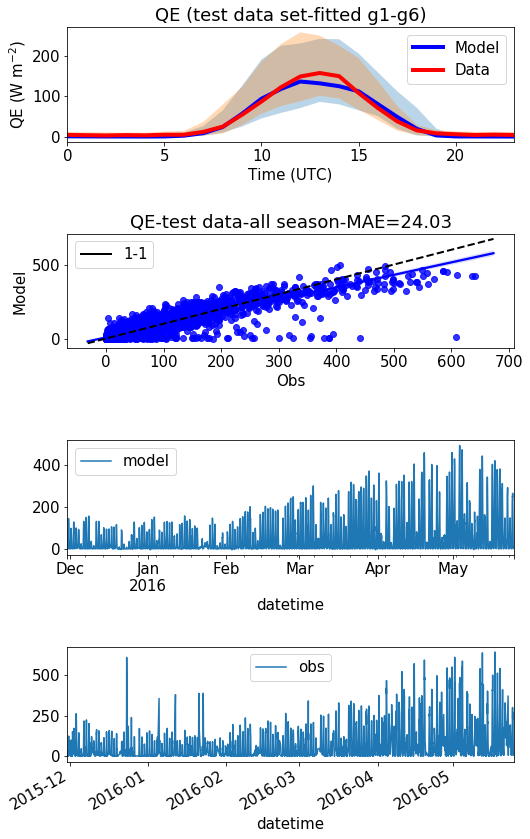

In [892]:
year=2015
w='wo'
name='cropw'
lai=cal_all_lai_model(year)
df_forcing_run_2,df_state_init,grid,d1,d2=forcing(year,name,lai)
alpha=4
df_obs,df_output, df_state_init,df_forcing_run_2=gs_plot_test(coef,lai,d1,d2,g1,g2,g3,g4,g5,g6,g_max,s1,name,year,alpha)

In [893]:
coef

[0.283263824, 0.784197374, -18]

In [894]:
alpha*g1*g_max

1032.6707407469296

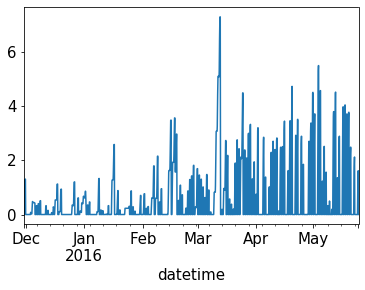

In [895]:
df_output.SUEWS.SMD.loc[grid,:].resample('1h',closed='left',label='right').mean().plot()

In [896]:
df_obs=df_obs[df_obs.rain==0]
df_mod=df_output.SUEWS.QE.loc[grid,:].resample('1h',closed='left',label='right').mean()
qe_obs=df_obs[(df_obs.qe>0)&(df_obs.qe<900)].qe

In [897]:
qe_mod=df_mod.loc[qe_obs.index].dropna()

In [898]:
diff_qe=(qe_obs-qe_mod)
abnorm=diff_qe[diff_qe>250]
abnorm=abnorm[qe_mod[abnorm.index]<100]

In [899]:
abnorm

datetime
2015-12-23 12:00:00    600.589873
2016-01-05 08:00:00    337.105529
2016-01-11 20:00:00    379.051017
2016-01-21 03:00:00    386.588530
2016-01-22 20:00:00    387.466484
2016-04-06 13:00:00    295.503984
2016-04-15 00:00:00    299.043278
2016-04-17 19:00:00    318.442487
2016-04-26 08:00:00    360.738579
2016-04-27 04:00:00    257.061308
2016-05-02 21:00:00    354.454367
2016-05-12 21:00:00    438.741673
dtype: float64

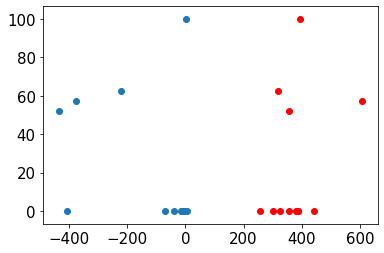

In [900]:
plt.scatter(df_obs.loc[abnorm.index,['qe']],df_obs.loc[abnorm.index,['kdown']],color='r')
plt.scatter(df_obs.loc[abnorm.index,['qh']],df_obs.loc[abnorm.index,['kdown']])

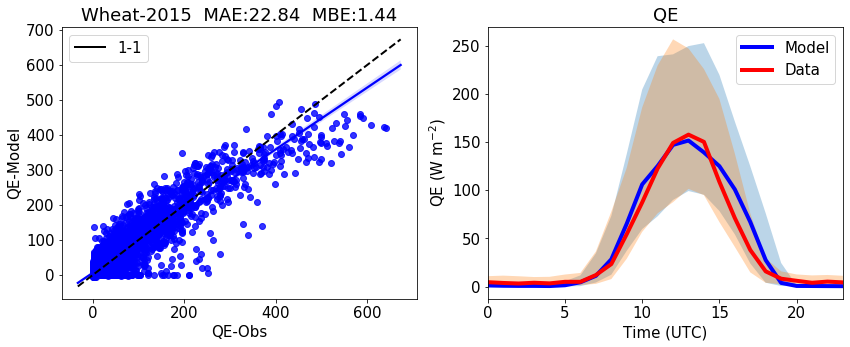

In [901]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
df_obs_temp=df_obs.replace(-999,np.nan)
df_obs_temp=df_obs_temp[~df_obs_temp.index.isin(abnorm.index)]
df_obs_temp=df_obs_temp[df_obs_temp.qe<900]
df=df_output.SUEWS.loc[grid,:]
df=df.resample('1h',closed='left',label='right').mean()
# IQR_compare('qe','QE',df_obs,df,ax)
ax=axs[0]
MAE=np.round(np.mean(abs(df_obs_temp.qe-df.loc[df_obs_temp.index,:].QE)),2)
MBE=np.round(np.mean((df_obs_temp.qe-df.loc[df_obs_temp.index,:].QE)),2)


obs_sim('qe','QE',df_obs_temp,df.loc[df_obs_temp.index,:],ax)
ax.set_ylabel('QE-Model')
ax.set_xlabel('QE-Obs')
ax.set_title('Wheat-'+str(year))
ax.set_title('Wheat-'+str(year)+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))

ax=axs[1]
IQR_compare('qe','QE',df_obs_temp,df.loc[df_obs_temp.index,:],ax)
ax.legend()
ax.set_title('QE')
ax.set_ylabel('QE (W m$^{-2}$)')
ax.set_xlabel('Time (UTC)')
plt.savefig('Wheat-QE-'+str(year)+w+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

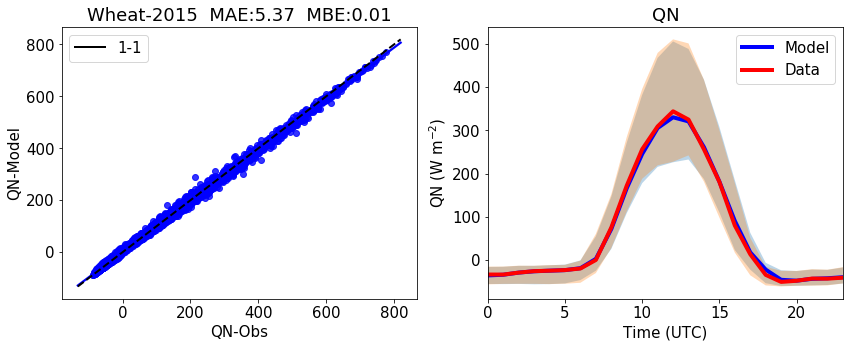

In [902]:
fig,axs=plt.subplots(1,2,figsize=(14,5))
ax=axs[0]
obs_sim('qn','QN',df_obs_temp,df.loc[df_obs_temp.index,:],ax)
MAE=np.round(np.mean(abs(df_obs_temp.qn-df.loc[df_obs_temp.index,:].QN)),2)
MBE=np.round(np.mean((df_obs_temp.qn-df.loc[df_obs_temp.index,:].QN)),2)

ax.set_ylabel('QN-Model')
ax.set_xlabel('QN-Obs')
ax.set_title('Wheat-'+str(year)+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))


ax=axs[1]
IQR_compare('qn','QN',df_obs_temp,df.loc[df_obs_temp.index,:],ax)
ax.legend()
ax.set_title('QN')
ax.set_ylabel('QN (W m$^{-2}$)')
ax.set_xlabel('Time (UTC)')
plt.savefig('Wheat-QN-'+str(year)+w+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

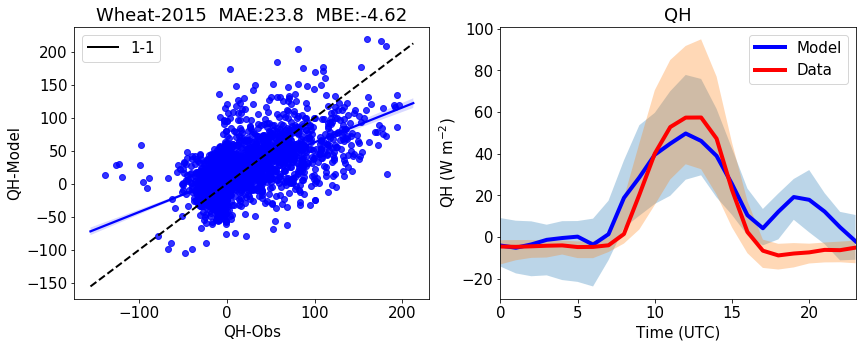

In [903]:
df_obs_temp=df_obs_temp[(df_obs_temp.qh<250)&(df_obs_temp.qh>-150)]
fig,axs=plt.subplots(1,2,figsize=(14,5))
ax=axs[0]
obs_sim('qh','QH',df_obs_temp,df.loc[df_obs_temp.index,:],ax)

MAE=np.round(np.mean(abs(df_obs_temp.qh-df.loc[df_obs_temp.index,:].QH)),2)
MBE=np.round(np.mean((df_obs_temp.qh-df.loc[df_obs_temp.index,:].QH)),2)
ax.set_ylabel('QH-Model')
ax.set_xlabel('QH-Obs')
ax.set_title('Wheat-'+str(year)+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))


ax=axs[1]
IQR_compare('qh','QH',df_obs_temp,df.loc[df_obs_temp.index,:],ax)
ax.legend()
ax.set_title('QH')
ax.set_ylabel('QH (W m$^{-2}$)')
ax.set_xlabel('Time (UTC)')
plt.savefig('Wheat-QH-'+str(year)+w+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

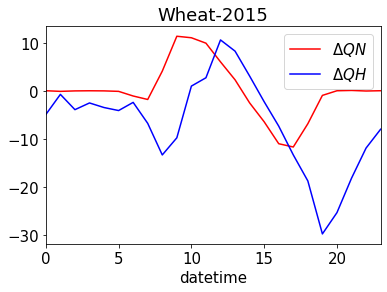

In [904]:
delqh=df_obs_temp.qh-df.loc[df_obs_temp.index,:].QH
delqn=df_obs_temp.qn-df.loc[df_obs_temp.index,:].QN
delqn.groupby(delqn.index.hour).median().plot(color='r',label='$\Delta QN$')
delqh.groupby(delqh.index.hour).median().plot(color='b',label='$\Delta QH$')
plt.title('Wheat-'+str(year))
plt.legend()
plt.savefig('Wheat-diff-'+str(year)+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

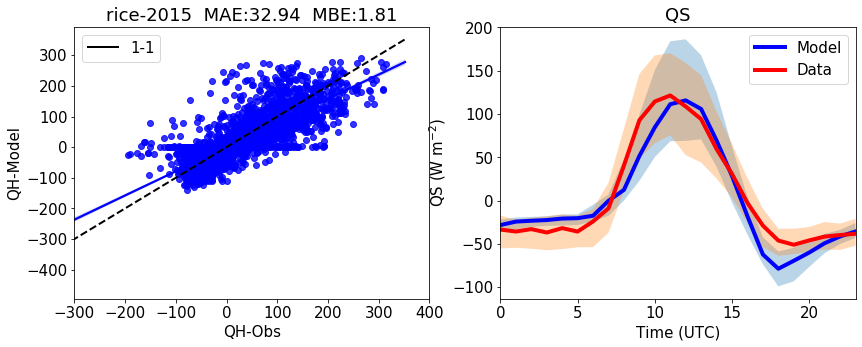

In [905]:
df_obs_temp['qs']=df_obs_temp.qn-df_obs_temp.qh-df_obs_temp.qe
df_obs_temp=df_obs_temp[(df_obs_temp.qh<250)&(df_obs_temp.qh>-150)]
fig,axs=plt.subplots(1,2,figsize=(14,5))
ax=axs[0]
obs_sim('qs','QS',df_obs_temp,df.loc[df_obs_temp.index,:],ax)

MAE=np.round(np.mean(abs(df_obs_temp.qs-df.loc[df_obs_temp.index,:].QS)),2)
MBE=np.round(np.mean((df_obs_temp.qs-df.loc[df_obs_temp.index,:].QS)),2)
ax.set_ylabel('QH-Model')
ax.set_xlabel('QH-Obs')
ax.set_title('rice-'+str(year)+'  MAE:'+str(MAE)+'  MBE:'+str(MBE))
ax.set_xlim([-300,400])

ax=axs[1]
IQR_compare('qs','QS',df_obs_temp,df.loc[df_obs_temp.index,:],ax)
ax.legend()
ax.set_title('QS')
ax.set_ylabel('QS (W m$^{-2}$)')
ax.set_xlabel('Time (UTC)')
plt.savefig('Wheat-QS-'+str(year)+w+'.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)